In [15]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

# Load the data
data = pd.read_csv('consumption_temp.csv')

# Filter for 'Oslo'
oslo_data = data[data['location'] == 'oslo']

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(oslo_data[['consumption', 'temperature']])

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    target = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        target.append([data[i+seq_length, 0]])  # Only select the 'consumption' column
    return torch.tensor(sequences).float(), torch.tensor(target).float()


seq_length = 24
X, y = create_sequences(scaled_data, seq_length)

# Split into training and test sets
train_size = int(0.8 * len(X))
X_train_seq = X[:train_size]
y_train_seq = y[:train_size]
X_test_seq = X[train_size:]
y_test_seq = y[train_size:]

# LSTM model definition
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm1(x, (h0.detach(), c0.detach()))
        out, (hn, cn) = self.lstm2(out)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# Initialize the model, criterion, optimizer, and scheduler
input_dim = 2
hidden_dim = 100
num_layers = 2
output_dim = 1
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

# Training loop
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_seq)
    loss = criterion(outputs, y_train_seq)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    model.eval()
    val_outputs = model(X_test_seq)
    val_loss = criterion(val_outputs, y_test_seq)
    val_losses.append(val_loss.item())
    
    scheduler.step()

# You can print or plot train_losses and val_losses to see the training progression
print(train_losses)
print(val_losses)



[0.8958160877227783, 0.8043079376220703, 0.6675703525543213, 0.622875452041626, 0.4776018559932709, 0.4359965920448303, 0.3745022118091583, 0.42422789335250854, 0.24211393296718597, 0.15466204285621643, 0.12528136372566223, 0.1319161057472229, 0.15406253933906555, 0.15099301934242249, 0.12356894463300705, 0.10123362392187119, 0.09629707038402557, 0.10244527459144592, 0.10102999955415726, 0.09766121953725815, 0.09990090876817703, 0.09865251183509827, 0.09066464006900787, 0.08126916736364365, 0.07534656673669815, 0.07485272735357285, 0.07112577557563782, 0.06654856353998184, 0.06494191288948059, 0.06584186106920242, 0.06353060156106949, 0.0610043965280056, 0.0563134141266346, 0.05222516134381294, 0.05106794089078903, 0.050166331231594086, 0.050485990941524506, 0.04915108159184456, 0.048979539424180984, 0.049183450639247894, 0.04894149303436279, 0.04779965803027153, 0.04601849243044853, 0.04484744369983673, 0.04438994824886322, 0.044861212372779846, 0.04523351788520813, 0.0445775799453258

In [23]:
print(X_train_seq.shape)
print(X_test_seq.shape)
print(y_train_seq.shape)
print(y_test_seq.shape)

torch.Size([6893, 24, 2])
torch.Size([1724, 24, 2])
torch.Size([6893, 1])
torch.Size([1724, 1])


In [25]:
import numpy as np

def make_predictions(new_data, model, scaler, seq_length):
    # Assuming new_data is a DataFrame with 'consumption' and 'temperature' columns
    
    # Standardize the new data
    scaled_new_data = scaler.transform(new_data[['consumption', 'temperature']])
    
   # If data is less than sequence length, pad it
    if len(scaled_new_data) <= seq_length:
        padding_length = seq_length + 1 - len(scaled_new_data)
        scaled_new_data = np.vstack((np.zeros((padding_length, scaled_new_data.shape[1])), scaled_new_data))

    
    # Create sequences from the standardized data
    X_new, _ = create_sequences(scaled_new_data, seq_length)  # We don't need the targets here
    
    # Add an additional dimension if only a single sequence is present
    if len(X_new.shape) == 2:
        X_new = X_new.unsqueeze(0)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        predictions = model(X_new)
    
    # Convert the scaled predictions back to the original scale
    predictions_np = predictions.cpu().numpy()
    predictions_combined = np.hstack((predictions_np, np.zeros((predictions_np.shape[0], 1))))
    predictions_original_scale = scaler.inverse_transform(predictions_combined)[:, 0]
    
    return predictions_original_scale

# Example usage:
new_data = pd.DataFrame({"consumption": [100, 150, 200], "temperature": [15, 16, 17]})  # Just a dummy example
predicted_consumption = make_predictions(new_data, model, scaler, seq_length)
print(predicted_consumption)

torch.Size([1, 24, 2])
[10.21807779]


Mean Absolute Error (MAE): 0.23182065784931183
Mean Squared Error (MSE): 0.07747998088598251
Root Mean Squared Error (RMSE): 0.2783522605895996
R-squared: 0.37094687404383675


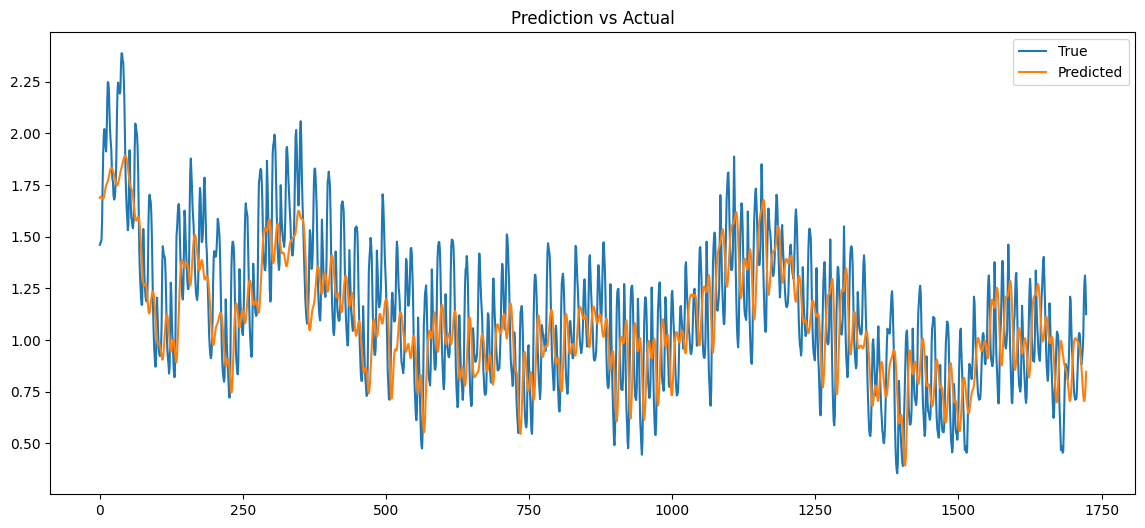

In [26]:
# Make predictions on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_seq)

# Convert predictions and actual values to numpy arrays for calculation
y_pred_np = y_pred.cpu().numpy()
y_test_np = y_test_seq.cpu().numpy()

# Compute Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_np, y_pred_np)
mse = mean_squared_error(y_test_np, y_pred_np)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

# Visual Inspection
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_test_np, label='True')
plt.plot(y_pred_np, label='Predicted')
plt.legend()
plt.title("Prediction vs Actual")
plt.show()
